In [75]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [85]:
# https://www.youtube.com/watch?v=TCH_1BHY58I&t=13s
# Based on https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

def get_words(dataset=3):
    datasets = ['../datasets/names.txt',
                '../datasets/male_names_rus.txt',
                '../datasets/female_names_rus.txt',
                '../datasets/russian_surnames.txt',
                '../datasets/towns.txt',
                '../datasets/animals.txt',
                '../datasets/spanish_male_names.txt',
                '../datasets/spanish_female_names.txt',
                '../datasets/spanish_surnames.txt',
                '../datasets/words-2.txt',
                '../datasets/words.txt']

    filename = datasets[dataset]

    if filename is None:
        print(f'Dataset "{dataset}" not found')
        return []
    
    data = open(filename, 'r').read().lower()

    if dataset == 3:
        data = data\
            .replace('a', 'а')\
            .replace('c', 'с')\
            .replace('k', 'к')\
            .replace('o', 'о')\
            .replace('\x1b', '')\
            .replace('1', '')
    if dataset == 5:
        data = data\
            .replace('(', '')\
            .replace(')', '')\
            .replace(',', '')\
            .replace('\'', '')
    
    words = [w.strip() for w in data.splitlines()]
    chars = ['.'] + sorted(list(set(''.join(words)))) # '.' is going to be used to indicate start and end of words
    stoi = {s: i for i, s in enumerate(chars)}
    itos = {i: s for s, i in stoi.items()}

    return words, chars, stoi, itos

In [92]:
words, chars, stoi, itos = get_words(9)

print(f'total words {len(words)}, total chars {len(chars)}, chars {chars}')
print(f'{words[:10]=}')

total words 1317, total chars 36, chars ['.', 'a', 'm', 'p', 's', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'ю', 'я']
words[:10]=['анус', 'аборт', 'бздун', 'беспезды', 'бздюх', 'бля', 'блудилище', 'блядво', 'блядеха', 'блядина']


In [93]:
def build_dataset(words, block, stoi):
    X, Y = [], []

    for w in words:
        context = [0] * block
        for y in w + '.':
            X.append(context)
            label = stoi[y]
            Y.append(label)
            context = context[1:] + [label]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [94]:
class MakerMLP():
    def __init__(self, X, Y, embd_size=2, hddn_size=50, btch_size=200, lr=0.2, lr_after_i=1000, lr_after=0.1):
        self.blck_size = X.shape[1] # block size

        # Hyper params
        self.embd_size = embd_size # embedding vector size
        self.hddn_size = hddn_size # hidden layer neurons
        self.btch_size = btch_size # batch size
        self.lr = lr               # initial learning rate
        self.l_count = 0
        self.loss = None
        self.g_layer = g = torch.Generator().manual_seed(2147483647)
        self.num_trains = 0
        self.lr_after_i = lr_after_i
        self.lr_after = lr_after

        self.X = X
        self.Y = Y
        
        self.init_params()

    def init_params(self):
        self.g_maker = g = torch.Generator().manual_seed(2147483647)

        self.C = torch.randn((len(chars), self.embd_size), requires_grad=True, generator=g)
        self.hddn_input_size = self.blck_size * self.embd_size

        self.W1 = torch.randn((self.hddn_input_size, self.hddn_size), requires_grad=True, generator=g)
        self.b1 = torch.randn(self.hddn_size, requires_grad=True, generator=g)

        self.W2 = torch.randn((self.hddn_size, len(chars)), requires_grad=True, generator=g)
        self.b2 = torch.randn(len(chars), requires_grad=True, generator=g)

        self.params = [self.C, self.W1, self.b1, self.W2, self.b2]

        # print(f'Total params: {sum(p.nelement() for p in self.params)}')
        
    def forward(self):
        ix = torch.randint(0, self.X.shape[0], (self.btch_size,)) # a random batch of input n-grams
        emb = self.C[self.X[ix]]
        h_layer = torch.tanh(emb.view(-1, self.hddn_input_size) @ self.W1 + self.b1)
        self.logits = h_layer @ self.W2 + self.b2

        # Torch cross_entropy() also includes softmax: -(logits.exp()/logits.exp().sum(dim=1)).log().mean(),
        #   see more here https://discuss.pytorch.org/t/softmax-cross-entropy-loss/125383
        self.loss = F.cross_entropy(self.logits, self.Y[ix])

        return self.logits

    def backward(self):
        for p in self.params:
            p.grad = None
        
        self.loss.backward() # the gradient

        # if self.loss.item() < 3:
        #     self.lr = 0.3

        for p in self.params:
            p.data += -self.lr * p.grad
            
    def plot_lr(self, size=50, n=500):
        # rng = torch.linspace(0.3, 0.5, size) # got the best loss in this range
        rng = 10**torch.linspace(-3, 0, size) # 0.001 - 1
        xs, ys = [], []
        for x in rng:
            self.lr = x
            xs.append(x)

            # The below line drops the weight matrices to the same random seed generated ones
            #   between each set of forth and back passes
            # If it is commented out the network will improve on every iteration
            #   through the entire range of values of the tested hyper parameter,
            #   which may be not what we want
            self.init_params()

            self.learn(n)

            ys.append(self.loss.item())

        plt.plot(xs, ys, label='lr')
        plt.xlabel('lr')
        plt.ylabel('loss')
        
    def plot_lr_after(self, n=500, size=40, after=500):
        rng = 10**torch.linspace(-3, 0, size) # 0.001 - 1
        xs, ys = [], []
        lr_pre = self.lr

        for x in rng:
            self.lr = lr_pre
            self.init_params()
            self.learn(after)

            self.lr = x
            self.learn(n)

            xs.append(x)
            ys.append(self.loss.item())

        plt.plot(xs, ys, label='lr')
        plt.xlabel('lr')
        plt.ylabel('loss')

    def plot_embd_size(self, n=500):
        rng = torch.arange(2, 32).int()
        xs, ys = [], []
        for x in rng:
            self.embd_size = x
            self.init_params()
            self.learn(n)

            xs.append(x)
            ys.append(self.loss.item())

        plt.plot(xs, ys, label='embedding size')
        plt.xlabel('size')
        plt.ylabel('loss')

    def plot_hddn_size(self, n=500):
        rng = torch.arange(25, 250, 5).int()
        xs, ys = [], []
        for x in rng:
            self.hddn_size = x
            self.init_params()
            self.learn(n)

            xs.append(x)
            ys.append(self.loss.item())

        plt.plot(xs, ys, label='hidden layer size')
        plt.xlabel('size')
        plt.ylabel('loss')
        
    def plot_btch_size(self, n=500):
        rng = torch.arange(10, 1000, 20).int()
        xs, ys = [], []
        for x in rng:
            self.btch_size = x
            self.init_params()
            self.learn(n)

            xs.append(x)
            ys.append(self.loss.item())

        plt.plot(xs, ys, label='forward pass batch size')
        plt.xlabel('size')
        plt.ylabel('loss')
    
    def make_one(self):
        context = [0] * self.blck_size # '...'
        word = []
        while True:
            emb = self.C[torch.tensor([context])] # [1, blck_size, embd_size]
            h_layer = torch.tanh(emb.view(1, -1) @ self.W1 + self.b1) # convert to 2d and let the view() figure out the second dimension via -1
            logits = h_layer @ self.W2 + self.b2
            prob = F.softmax(logits, dim=1) # logits.exp()/logits.exp().sum(dim=1)
            ix = torch.multinomial(prob, num_samples=1, generator=self.g_maker).item()
            context = context[1:] + [ix]
            word.append(itos[ix])
            if ix == 0:
                break

        return ''.join(word)

    def make_more(self, n):
        return [self.make_one() for _ in range(n)]
    
    def train(self):
        self.forward()
        self.backward()

    def learn(self, n=1000):
        for i in range(n):
            self.num_trains += 1
            if self.num_trains > self.lr_after_i:
                self.lr = self.lr_after
            self.train()
        self.forward()
        return self.loss
            

In [112]:
block = 3
# X, Y = build_dataset(words, block, stoi)

X, Y = build_dataset(words, block, stoi)

# mlp = MakerMLP(X, Y)
mlp = MakerMLP(X, Y, btch_size=280, embd_size=2, hddn_size=208, lr=0.1, lr_after_i=5000, lr_after=0.01) # names.txt

In [113]:
mlp.lr = 0.1
mlp.learn(10000)

tensor(1.0930, grad_fn=<NllLossBackward0>)

In [117]:
print('\n'.join(f'- {w[:-1]}' for w in mlp.make_more(30)))

- пискить
- продоливаться
- оть
- попомевать
- допизди
- пропиздобосхуячиться
- объебатлахуоъебашивать
- сдеить
- уасебачить
- ренуить
- обохать
- пропиздяриваться
- припиздяк
- обпивать
- охуяшивать
- прикь
- изхать
- миитрахуяриться
- но
- сапач
- уебан
- титься
- ребь
- запиздяшивать
- припиздякиваться
- допиздюкиваться
- примандихуюшаривать
- копиздеза
- въебихунстрохуякивать
- хадичь


In [111]:
mlp.plot_btch_size()

KeyboardInterrupt: 

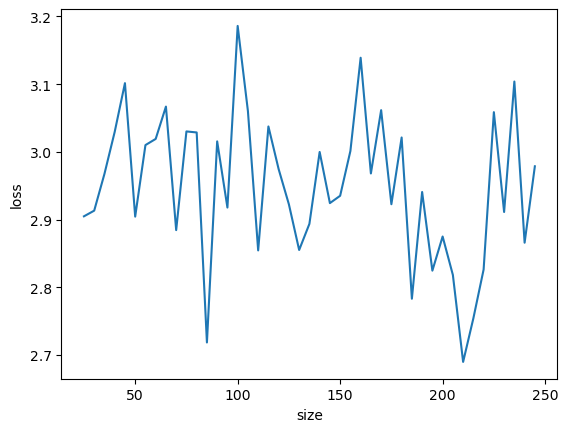

In [23]:
mlp.plot_hddn_size()

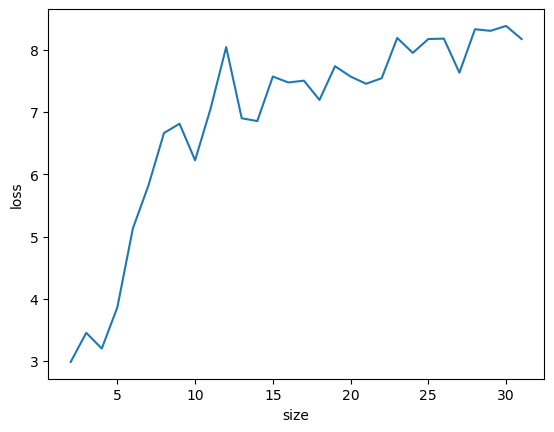

In [24]:
mlp.plot_embd_size()

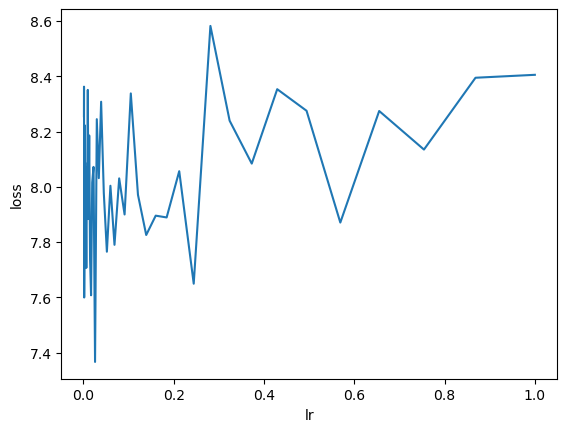

In [25]:
mlp.plot_lr()

In [ ]:
mlp.lr = 0.2
mlp.plot_lr_after(size=40, after=500)
# mlp.plot_lr_after()

In [ ]:
# In order to further improve Make More NN we want it to learn more than just one character of information
# So now the input will consist of multiple characters, the context; however we need to be careful now
#   as the amount of all possible bi-, tri-, quadri-, etc n-grams as well as the size of the weights tensor
#   will grow exponentially with each next character

block = 3 # input sequence length
X, Y = [], [] # the dataset

# for w in words[:5]:
for w in words:
    context = [0] * block
    # print(f'Word: "{w}"')
    for y in w + '.':
        X.append(context)
        label = stoi[y]
        Y.append(label)
        # print(f'{"".join([itos[i] for i in context])} ---> {y}')
        context = context[1:] + [label]

# Word: "emma"
# ... ---> e
# ..e ---> m
# .em ---> m
# emm ---> a
# mma ---> .

# The dataset
X = torch.tensor(X) # torch.Size([32, 3]) # 32 is the number of n-grams, 3 is n
Y = torch.tensor(Y) # torch.Size([32]) # labels for the above n-grams input

# X.shape, Y.shape

In [ ]:
# Now we are going to build a multi layer NN with architecture similar to the one described in the above paper

g = torch.Generator().manual_seed(2147483647)

# First we need to embed our input into a vector space
# The more possible input characters (words, whatever) we have the more dimensions the space should have
# In our case we have 27 possible characters, let's start with 2d embedding
# The embeding matrix is pretty much the same as regular weight matrix

emb_dim = 2
C = torch.randn((len(chars), emb_dim), generator=g) # torch.Size([27, 2]);

# And now we can move to the next, hidden layer where we want to have 100 neurons fully connected with the input
hid_dim = 100
W1 = torch.randn((h_input_dim, hid_dim), generator=g)
b1 = torch.randn(hid_dim, generator=g)

# Finally we build the next layer the output of which is probability distribution vector for 27 chars
W2 = torch.randn((hid_dim, len(chars)), generator=g)
b2 = torch.randn(len(chars), generator=g)

params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True

sum(p.nelement() for p in params) # Total number of NN params

In [ ]:
for i in range(1000):

    # Forward pass
    
    # Because we may have a lot of n-grams input, let's run everything on data minibatches
    ix = torch.randint(0, X.shape[0], (100,)) # 32 batch size

    # Before applying the embedding we usually encode input as one-hot vectors via which
    #   we then pick the i-th row from the embedding matrix (27, 2)
    # This is practically the same as selecting the row by index C[i]

    # X_enc = F.one_hot(torch.tensor(X), num_classes=27).float()
    # X_emb = X_enc @ C
    # X_emb, X.shape

    # is the same as just

    emb = C[X[ix]] # torch.Size([32, 3, 2])
    # Here because X is (32, 3) and each row in X contains 3 chars the matrix C (27, 2) is indexed by,
    #   so for each char we now have a vector (2), and hence the shape of the result is (32, 3, 2)

    # Because our input is a set of (3, 2) vectors representing n-grams, for convenience we can flatten it
    #   into a single (6) vector simply concatenating all three pairs for each n-gram

    h_input_dim = block * emb_dim # input n-gram dimension = amount of characters times embedding vector dimension

    # We can acheive this multiple ways:
    # n_grams_1 = torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), 1) # 1 -> axis
    # n_grams_2 = torch.cat(torch.unbind(emb, 1), 1)

    # The above two ways turn out to be inefficient, as under the hood there will be new tensors created
    # n_grams_3 = emb.view(32, 6) # or emb.view(-1, 6) # Using torch native features is recommended here

    # h_layer = torch.tanh(emb.view(emb.shape[0], h_input_dim) @ W1 + b1) # Same as below
    h_layer = torch.tanh(emb.view(-1, h_input_dim) @ W1 + b1) # torch.Size([32, 100]),

    logits = h_layer @ W2 + b2 # torch.Size([32, 27]

    # count = logits.exp()
    # prob = count / count.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean() # 32 → X.shape[0]

    # Instead of the above 3 lines it is recommended to use pytorch library function (exactly the same result)
    # In fact the below function is so much more efficient that
    #   the above (educational) code should never be used for cross_entropy

    loss = F.cross_entropy(logits, Y[ix])
    # print(f'loss {loss.item()}')

    # Back propagation

    # 1. Set grad to 0
    for p in params:
        p.grad = None

    # 2. Gradient descent
    loss.backward()

    # 3. Optimization
    for p in params:
        p.data += -0.1 * p.grad

print(f'loss {loss.item()}')